### MAL Project - Mobile Churn Forecasting
Mattéo Rousseau & Massil Gouachi


In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier


#--- Data importation ---
cell = pd.read_csv("celldata.csv")

features = [feature for feature in cell.columns if feature != "Churn"]
X, y = cell[features].copy(), cell[["Churn"]].copy()

types = {
    "CreditScore": "int64",
    "Age": "int64",
    "Tenure": "int64",
    "Balance": "float64",
    "NumOfProducts": "int64",
    "Salary": "int64",
    "Geography": "category",
    "Gender": "category",
    "HasCrCard": "boolean",
    "IsActiveMember": "boolean",
}

X = X.astype(types)
y = y.astype({"Churn": "boolean"})

### Part I - Data exploration

In [61]:
cell.head()


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Salary,Churn
0,632,Germany,Female,50,5,107959.39,1,1,1,6985,1
1,649,France,Female,42,7,0.00,2,0,1,22974,0
2,595,France,Male,29,6,150685.79,1,1,0,87771,0
3,653,Spain,Male,35,6,116662.96,2,1,1,23864,0
4,559,Spain,Female,40,7,144470.77,1,1,1,18918,0


In [62]:
cell.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CreditScore     8000 non-null   int64  
 1   Geography       8000 non-null   object 
 2   Gender          8000 non-null   object 
 3   Age             8000 non-null   int64  
 4   Tenure          8000 non-null   int64  
 5   Balance         8000 non-null   float64
 6   NumOfProducts   8000 non-null   int64  
 7   HasCrCard       8000 non-null   int64  
 8   IsActiveMember  8000 non-null   int64  
 9   Salary          8000 non-null   int64  
 10  Churn           8000 non-null   int64  
dtypes: float64(1), int64(8), object(2)
memory usage: 687.6+ KB


In [63]:
cell.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Salary,Churn
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,650.805000,38.871625,5.013000,76011.635494,1.533625,0.704750,0.515750,100211.396750,0.201125
std,96.721648,10.446006,2.897565,62402.105212,0.583448,0.456184,0.499783,57165.688096,0.400866
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,12.000000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.000000,0.000000,51464.500000,0.000000
50%,652.000000,37.000000,5.000000,96846.565000,1.000000,1.000000,1.000000,100583.000000,0.000000
75%,718.000000,44.000000,7.000000,127593.625000,2.000000,1.000000,1.000000,149068.000000,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.000000,1.000000


In [64]:
cell.isna().sum()

CreditScore       0
Geography         0
Gender            0
Age               0
Tenure            0
Balance           0
NumOfProducts     0
HasCrCard         0
IsActiveMember    0
Salary            0
Churn             0
dtype: int64

In [65]:
cat_cols = ["Geography", "Gender", "HasCrCard", "IsActiveMember"]
num_cols = ["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "Salary"]

X[cat_cols].nunique()

Geography         3
Gender            2
HasCrCard         2
IsActiveMember    2
dtype: int64

In [66]:
X[cat_cols].value_counts()

Geography  Gender  HasCrCard  IsActiveMember
France     Male    True       True              828
                              False             756
           Female  True       True              646
                              False             612
Spain      Male    True       True              405
Germany    Male    True       True              386
                              False             367
           Female  True       False             357
Spain      Male    True       False             357
France     Male    False      True              329
                              False             313
Spain      Female  True       True              310
Germany    Female  True       True              308
Spain      Female  True       False             306
France     Female  False      True              282
                              False             272
Spain      Male    False      True              196
                              False             154
Germany    Male    

=== Barplots des variables catégorielles ===


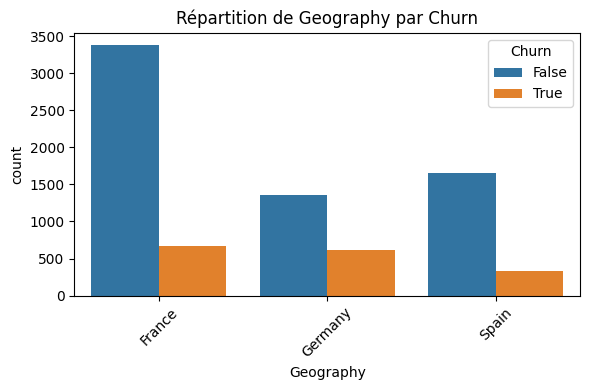

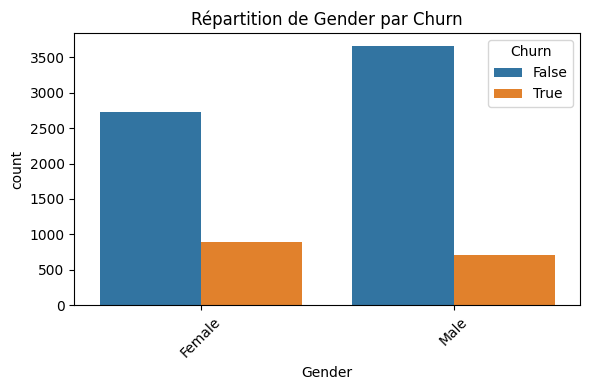

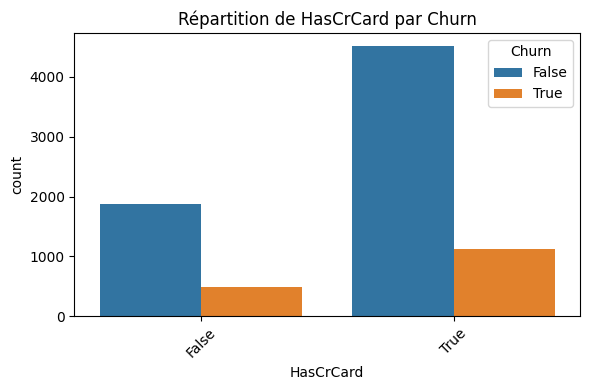

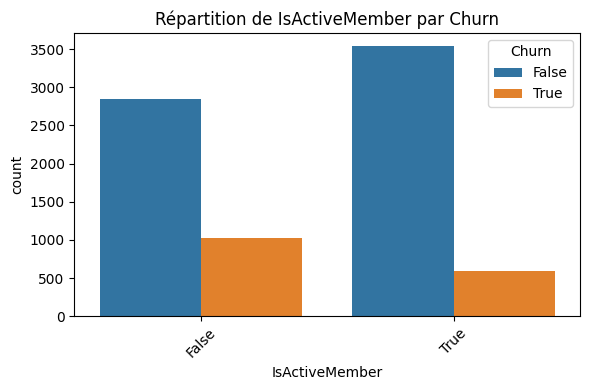

=== Histogrammes & Boxplots des variables numériques ===


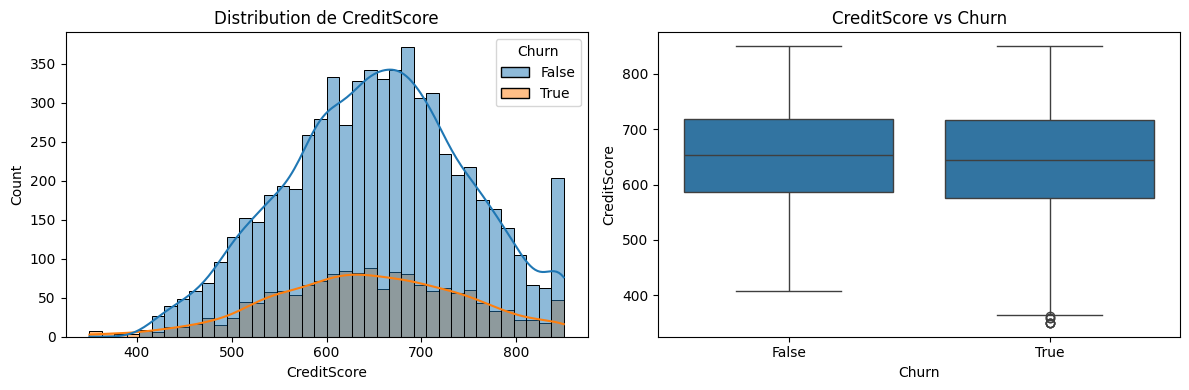

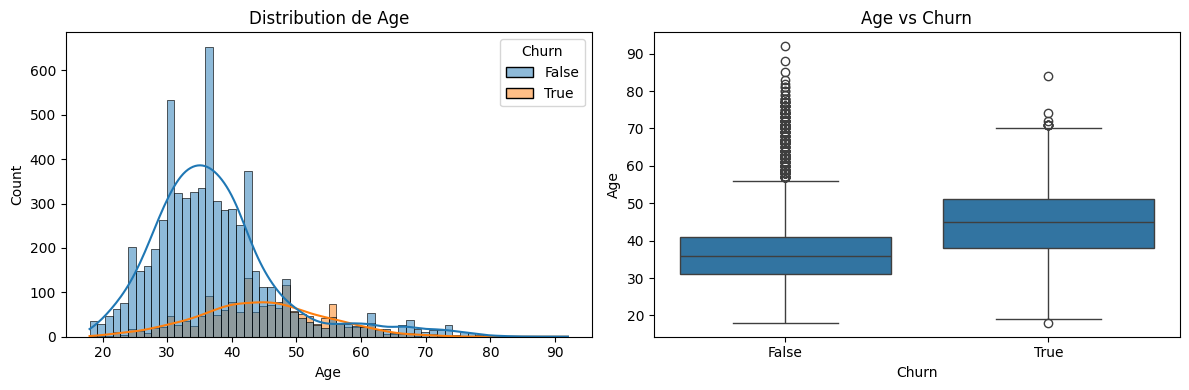

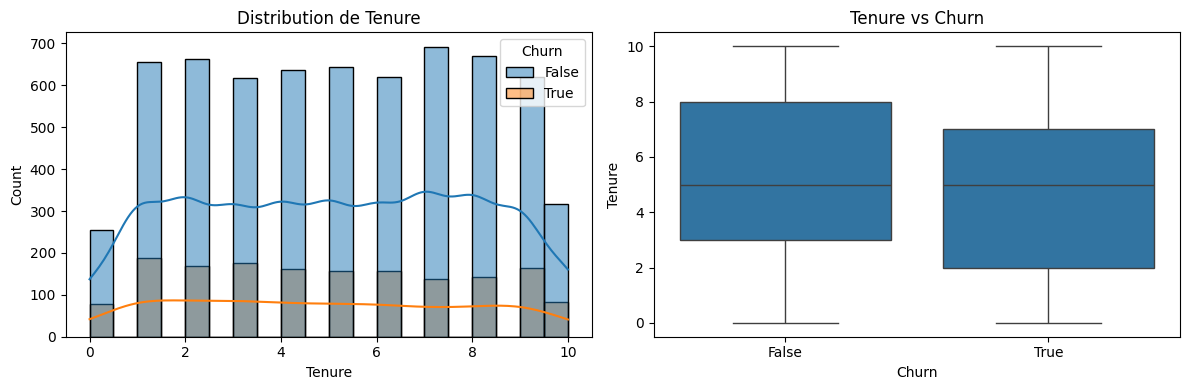

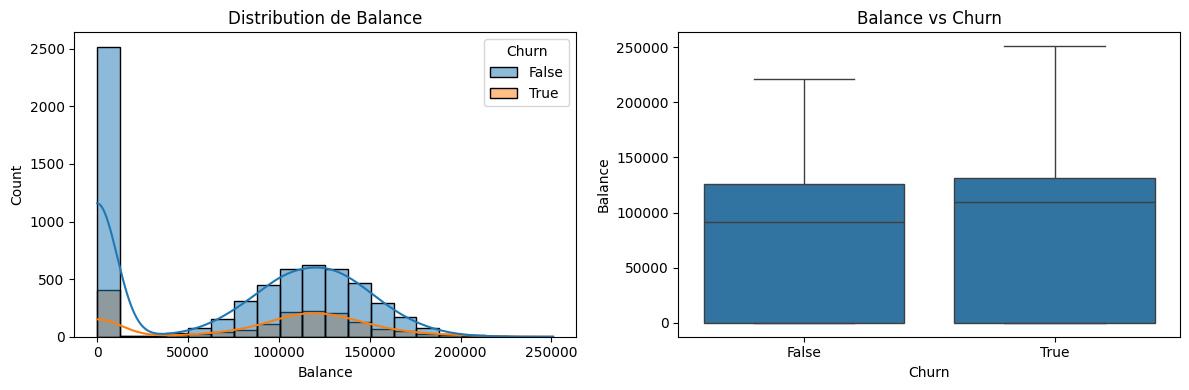

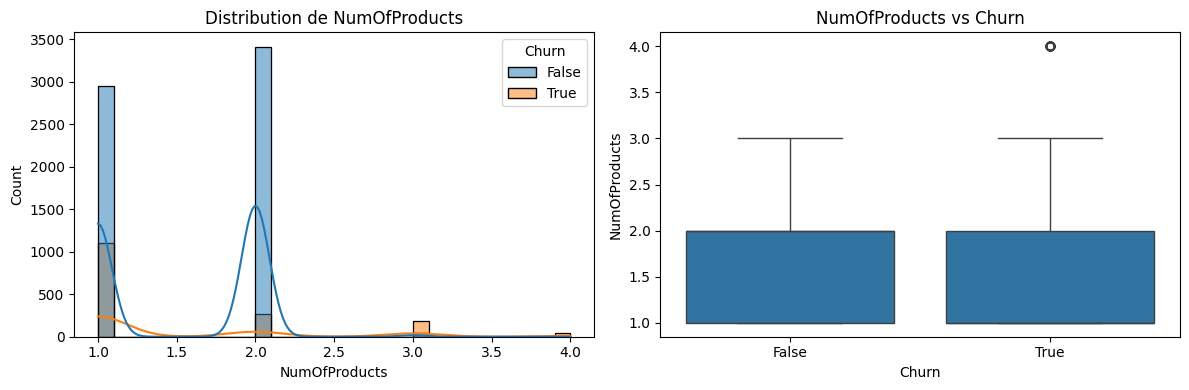

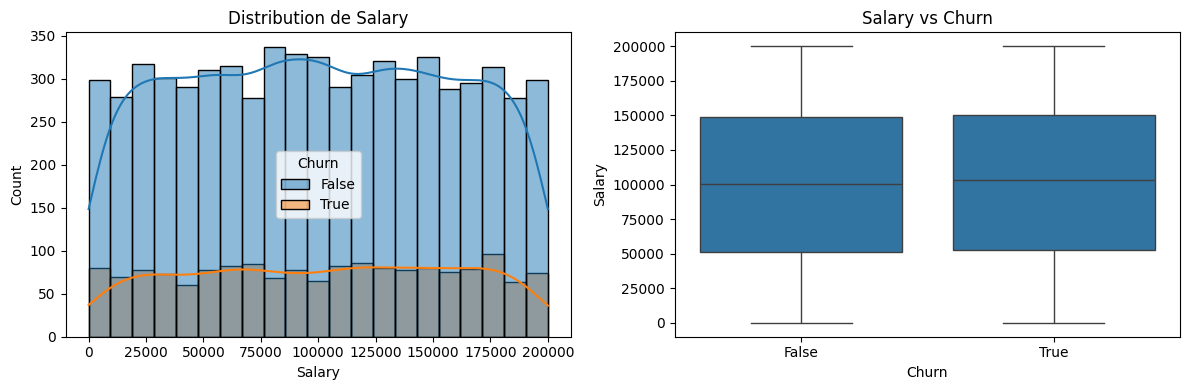

=== Heatmap de corrélation avec la cible ===


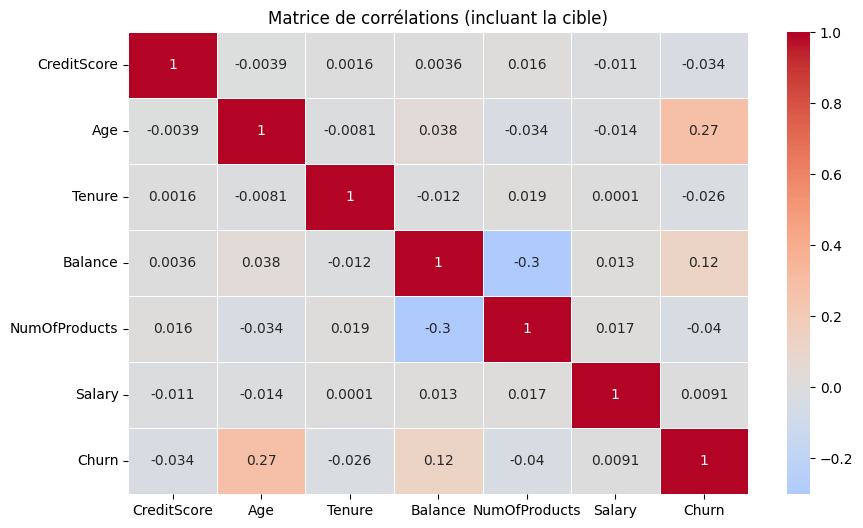

In [67]:
df = X.copy()
df["Churn"] = y["Churn"]
target = "Churn"


print("=== Barplots des variables catégorielles ===")
for col in cat_cols:
    if col == target:
        continue
        
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x=col, hue=target)
    plt.title(f"Répartition de {col} par Churn")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


print("=== Histogrammes & Boxplots des variables numériques ===")
for col in num_cols:
    
    fig, ax = plt.subplots(1, 2, figsize=(12,4))

    # Histogram
    sns.histplot(df, x=col, hue=target, kde=True, ax=ax[0])
    ax[0].set_title(f"Distribution de {col}")

    # Boxplot
    sns.boxplot(data=df, x=target, y=col, ax=ax[1])
    ax[1].set_title(f"{col} vs {target}")

    plt.tight_layout()
    plt.show()


print("=== Heatmap de corrélation avec la cible ===")
# encoder la cible en 0/1 pour corr
df_corr = df.copy()
df_corr["Churn"] = df_corr["Churn"].astype(int)

corr = df_corr[num_cols + ["Churn"]].corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, linewidths=.5)
plt.title("Matrice de corrélations (incluant la cible)")
plt.show()

In [68]:
df = X.copy()

encoder = OneHotEncoder(sparse_output=False)
X_cat = encoder.fit_transform(df[cat_cols])
X_num = df[num_cols].values
X_encoded = np.hstack((X_num, X_cat))

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate="auto",
    init="random",
    random_state=0
)

X_tsne = tsne.fit_transform(X_encoded)

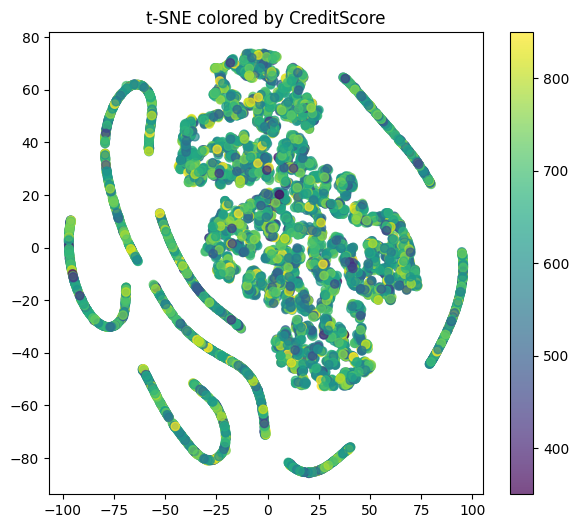

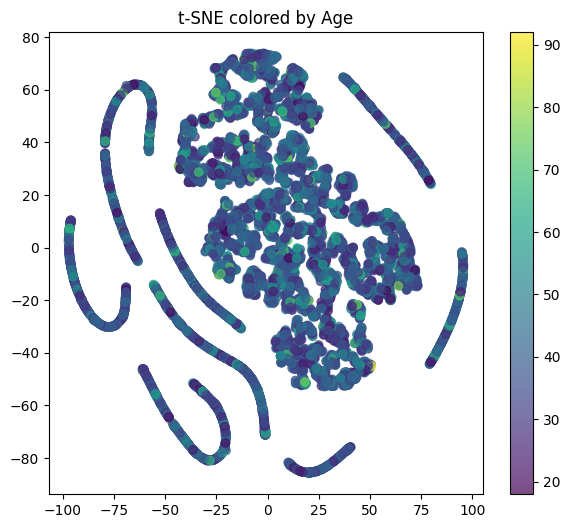

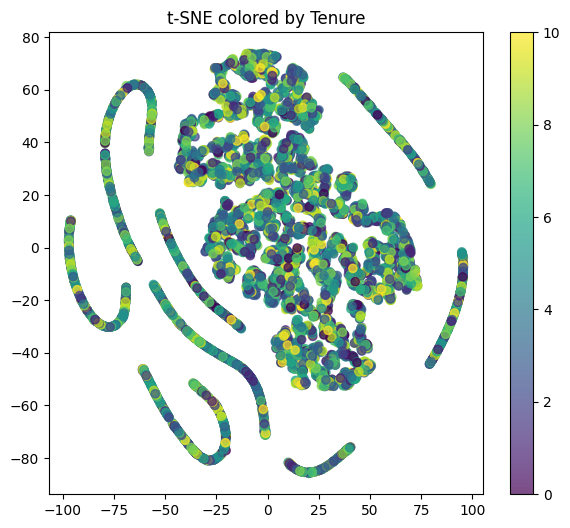

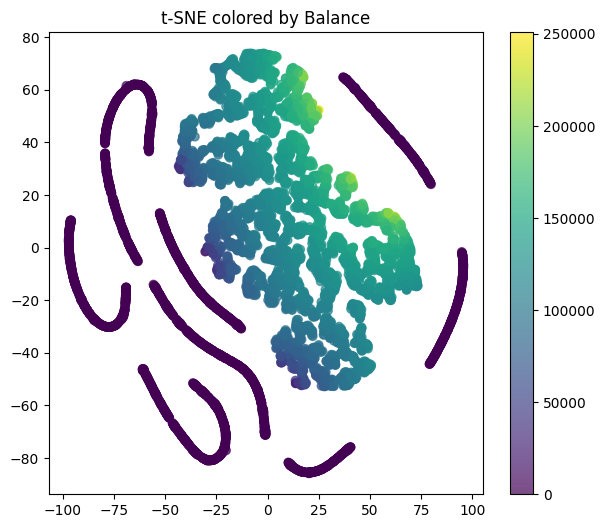

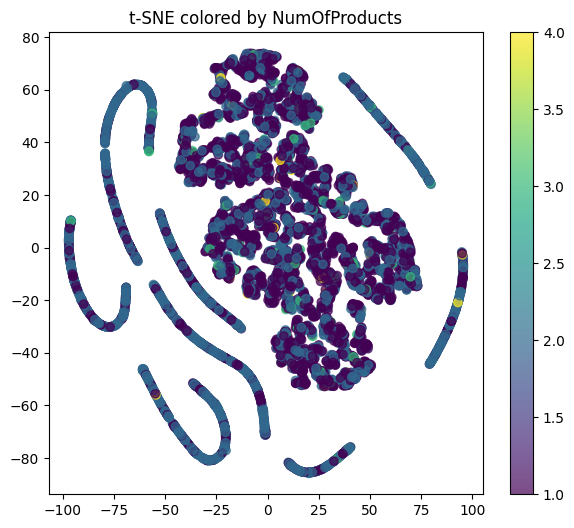

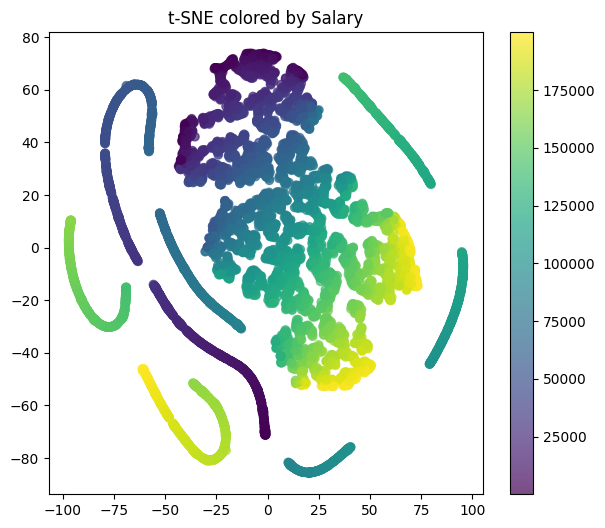

In [69]:
for col in num_cols:
    plt.figure(figsize=(7,6))
    plt.title(f"t-SNE colored by {col}")
    plt.scatter(X_tsne[:,0], X_tsne[:,1], c=df[col], cmap="viridis", alpha=0.7)
    plt.colorbar()
    plt.show()

### Part II - Data processing

In [70]:
X_cv, X_eval, y_cv, y_eval = train_test_split(X, y, test_size=1/8, random_state=42)

OHE = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
X_cv_cat = OHE.fit_transform(X_cv[cat_cols])
X_eval_cat = OHE.transform(X_eval[cat_cols])

scaler = StandardScaler()
X_cv_num = scaler.fit_transform(X_cv[num_cols])
X_eval_num = scaler.transform(X_eval[num_cols])

X_cv = np.hstack([X_cv_num, X_cv_cat])
X_eval = np.hstack([X_eval_num, X_eval_cat])

y_cv = y_cv.to_numpy().ravel()
y_eval = y_eval.to_numpy().ravel()

### Part III - Model training

In [71]:
logreg = LogisticRegression(solver="saga", max_iter=200, random_state=0)
logreg_dist = [
    {
        "penalty": ["l1", "l2"],
        "C": uniform(loc=0, scale=4)
    },
    {
        "penalty": ["elasticnet"],
        "C": uniform(loc=0, scale=4),
        "l1_ratio": uniform()
    }
]

logreg_clf = RandomizedSearchCV(logreg, logreg_dist, n_iter=100, random_state=0)
logreg_search = logreg_clf.fit(X_cv, y_cv)
logreg_eval_score = logreg_search.best_estimator_.score(X_eval, y_eval)
print(f"Logistic Regression cross-validation score: {logreg_search.best_score_:5f}")
print(f"Logistic Regression evaluation score: {logreg_eval_score:5f}")
print(f"Best parameters: {logreg_search.best_params_}")

Logistic Regression cross-validation score: 0.811714
Logistic Regression evaluation score: 0.814000
Best parameters: {'C': np.float64(0.1537017058909389), 'l1_ratio': np.float64(0.634274057957335), 'penalty': 'elasticnet'}


In [72]:
kNN = KNeighborsClassifier()
kNN_dist = dict(
    n_neighbors=range(1, 20),
    weights=["uniform", "distance"]
)

kNN_clf = GridSearchCV(kNN, kNN_dist)
kNN_search = kNN_clf.fit(X_cv, y_cv)
kNN_eval_score = kNN_search.best_estimator_.score(X_eval, y_eval)
print(f"k Neirest Neighbors cross-validation score: {kNN_search.best_score_:5f}")
print(f"k Neirest Neighbors evaluation score: {kNN_eval_score:5f}")
print(f"Best parameters: {kNN_search.best_params_}")

k Neirest Neighbors cross-validation score: 0.852857
k Neirest Neighbors evaluation score: 0.846000
Best parameters: {'n_neighbors': 18, 'weights': 'distance'}


In [73]:
LDA = LinearDiscriminantAnalysis(solver="lsqr")
LDA_dist = dict(
    shrinkage=uniform()
)

LDA_clf = RandomizedSearchCV(LDA, LDA_dist, n_iter=100)
LDA_search = LDA_clf.fit(X_cv, y_cv)
LDA_eval_score = LDA_search.best_estimator_.score(X_eval, y_eval)
print(f"Linear Discriminant Analysis cross-validation score: {LDA_search.best_score_:5f}")
print(f"Linear Discriminant Analysis evaluation score: {LDA_eval_score:5f}")
print(f"Best parameters: {LDA_search.best_params_}")

Linear Discriminant Analysis cross-validation score: 0.809286
Linear Discriminant Analysis evaluation score: 0.802000
Best parameters: {'shrinkage': np.float64(0.028328693981226616)}


In [74]:
QDA = QuadraticDiscriminantAnalysis()
QDA_dist = dict(
    reg_param=uniform(),
)

QDA_clf = RandomizedSearchCV(QDA, QDA_dist, n_iter=100)
QDA_search = QDA_clf.fit(X_cv, y_cv)
QDA_eval_score = QDA_search.best_estimator_.score(X_eval, y_eval)
print(f"Quadratic Discriminant Analysis cross-validation score: {QDA_search.best_score_:5f}")
print(f"Quadratic Discriminant Analysis evaluation score: {QDA_eval_score:5f}")
print(f"Best parameters: {QDA_search.best_params_}")

Quadratic Discriminant Analysis cross-validation score: 0.837000
Quadratic Discriminant Analysis evaluation score: 0.839000
Best parameters: {'reg_param': np.float64(0.07031007058971805)}


In [75]:
# gaussian_process = GaussianProcessClassifier()
# gaussian_process_dist = dict(
#     kernel=[RBF(), Matern(), RationalQuadratic(), ExpSineSquared()],  
# )

# gaussian_process_clf = RandomizedSearchCV(gaussian_process, gaussian_process_dist)
# gaussian_process_search = gaussian_process_clf.fit(X_cv, y_cv)
# gaussian_process_eval_score = gaussian_process_search.best_estimator_.score(X_eval, y_eval)
# print(f"Support Vector Classification evaluation score: {gaussian_process_eval_score:5f}")
# print(f"Best parameters: {gaussian_process_search.best_params_}")

In [76]:
svc = SVC()
svc_dist = [
    {
        "kernel": ["poly"],
        "C": uniform(loc=0, scale=4),
        "degree": range(1, 5)
    },
    {
        "kernel": ["rbf", "sigmoid"],
        "C": uniform(loc=0, scale=4),
    }
]

svc_clf = RandomizedSearchCV(svc, svc_dist)
svc_search = svc_clf.fit(X_cv, y_cv)
svc_eval_score = svc_search.best_estimator_.score(X_eval, y_eval)
print(f"Support Vector Classification cross-validation score: {svc_search.best_score_:5f}")
print(f"Support Vector Classification evaluation score: {svc_eval_score:5f}")
print(f"Best parameters: {svc_search.best_params_}")

Support Vector Classification cross-validation score: 0.860857
Support Vector Classification evaluation score: 0.855000
Best parameters: {'C': np.float64(3.2790217265532364), 'kernel': 'rbf'}


In [77]:
GNB = GaussianNB()
GNB_dist = {
    "var_smoothing": uniform(loc=0, scale=1e-3)
}

GNB_clf = RandomizedSearchCV(GNB, GNB_dist, n_iter=100)
GNB_search = GNB_clf.fit(X_cv, y_cv)
GNB_eval_score = GNB_search.best_estimator_.score(X_eval, y_eval)
print(f"Gaussian Naive Bayes cross-validation score: {GNB_search.best_score_:5f}")
print(f"Gaussian Naive Bayes evaluation score: {GNB_eval_score:5f}")
print(f"Best parameters: {GNB_search.best_params_}")

Gaussian Naive Bayes cross-validation score: 0.825571
Gaussian Naive Bayes evaluation score: 0.827000
Best parameters: {'var_smoothing': np.float64(0.0005195232656697292)}


In [78]:
# grad_boost = GradientBoostingClassifier()
# grad_boost_dist = {
#     "loss": ["log_loss", "deviance", "exponential"],
#     "learning_rate": uniform(loc=1e-6, scale=1e-2),
#     "n_estimators": [100, 200, 300, 400],
#     "max_depth": [3, 5, 7, 9]
# }

# grad_boost_clf = RandomizedSearchCV(grad_boost, grad_boost_dist, n_iter=100)
# grad_boost_search = grad_boost_clf.fit(X_cv, y_cv)
# grad_boost_eval_score = grad_boost_search.best_estimator_.score(X_eval, y_eval)
# print(f"Gaussian Naive Bayes evaluation score: {grad_boost_eval_score:5f}")
# print(f"Best parameters: {grad_boost_search.best_params_}")

In [79]:
hist_grad_boost = HistGradientBoostingClassifier(max_iter=200)
hist_grad_boost_dist = {
    "learning_rate": uniform(loc=1e-6, scale=1e-2),
    "max_depth": [3, 5, 7, 9, 11],
    "l2_regularization": uniform()
}

hist_grad_boost_clf = RandomizedSearchCV(hist_grad_boost, hist_grad_boost_dist, n_iter=20)
hist_grad_boost_search = hist_grad_boost_clf.fit(X_cv, y_cv)
hist_grad_boost_eval_score = hist_grad_boost_search.best_estimator_.score(X_eval, y_eval)
print(f"Histogram Gradient Boosting cross-validation score: {hist_grad_boost_search.best_score_:5f}")
print(f"Histogram Gradient Boosting evaluation score: {hist_grad_boost_eval_score:5f}")
print(f"Best parameters: {hist_grad_boost_search.best_params_}")

Histogram Gradient Boosting cross-validation score: 0.864571
Histogram Gradient Boosting evaluation score: 0.855000
Best parameters: {'l2_regularization': np.float64(0.4380803567556357), 'learning_rate': np.float64(0.009853642374302533), 'max_depth': 7}


In [80]:
RF = RandomForestClassifier()
RF_dist = {
    "max_depth": [3, 5, 7, 9, 11, 13],
    "n_estimators": [100, 200, 300, 400],
    "min_samples_split": [2, 5, 10, 15],
}

RF_clf = RandomizedSearchCV(RF, RF_dist, n_iter=20)
RF_search = RF_clf.fit(X_cv, y_cv)
RF_eval_score = RF_search.best_estimator_.score(X_eval, y_eval)
print(f"Random Forest cross-validation score: {RF_search.best_score_:5f}")
print(f"Random Forest evaluation score: {RF_eval_score:5f}")
print(f"Best parameters: {RF_search.best_params_}")

Random Forest cross-validation score: 0.868143
Random Forest evaluation score: 0.861000
Best parameters: {'n_estimators': 300, 'min_samples_split': 10, 'max_depth': 13}


In [81]:
extratrees = ExtraTreesClassifier()
extratrees_dist = {
    "max_depth": [3, 5, 7, 9, 11, 13],
    "n_estimators": [100, 200, 300, 400],
    "min_samples_split": [2, 5, 10, 15],
}

extratrees_clf = RandomizedSearchCV(extratrees, extratrees_dist, n_iter=20)
extratrees_search = extratrees_clf.fit(X_cv, y_cv)
extratrees_eval_score = extratrees_search.best_estimator_.score(X_eval, y_eval)
print(f"Extra Trees cross-validation score: {extratrees_search.best_score_:5f}")
print(f"Extra Trees evaluation score: {extratrees_eval_score:5f}")
print(f"Best parameters: {extratrees_search.best_params_}")

Extra Trees cross-validation score: 0.862571
Extra Trees evaluation score: 0.848000
Best parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 13}


In [82]:
rf_adaboost = RandomForestClassifier(n_estimators=50, min_samples_split=10, max_depth=5)
adaboost_rf = AdaBoostClassifier(estimator=rf_adaboost, learning_rate=0.7).fit(X_cv, y_cv)
print(f"Adaboost + RF training score: {adaboost_rf.score(X_cv, y_cv):5f}")
print(f"Adaboost + RF evaluation score: {adaboost_rf.score(X_eval, y_eval):5f}")

Adaboost + RF training score: 0.996857
Adaboost + RF evaluation score: 0.834000
